In [4]:
# %load simulation.py
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from scipy.ndimage import convolve


class Model:
    def __init__(self,
                 n=512,
                 m=128,
                 # probability that an active trader can turn one of his inactive neighbors into an active one
                 p_h=0.0485,
                 # probability to diffuse and become inactive when having at least one inactive neighbour
                 p_d=0.049,
                 # probability to spontaneously enter market dynamics
                 p_e=0.0001,
                 #
                 initial_active_freq=0.2
                 ):
        self.p_h = p_h
        self.p_e = p_e
        self.p_d = p_d
        self.n = n
        self.m = m

        self.ones = np.ones((self.n, self.m), dtype=np.byte)

        self.activeness_mask = np.random.random(self.n * self.m).reshape(
            (self.n, self.m)) < (self.ones * initial_active_freq)

        self.matrix = ma.masked_array(np.zeros((n, m), dtype=np.byte), mask=self.activeness_mask,
                                      fill_value=1)

        self.not_h_matrix = self.ones.astype(dtype=np.float64) * (1 - p_h)
        self.h_matrix = self.ones.astype(dtype=np.float64) * p_h
        self.not_e_matrix = self.ones.astype(dtype=np.float64) * (1 - p_e)
        self.e_matrix = self.ones.astype(dtype=np.float64) * p_e
        self.d_matrix = self.ones.astype(dtype=np.float64) * p_d
        self.convolution_kernel_neighbours = np.array([[0, 1, 0],
                                                       [1, 0, 1],
                                                       [0, 1, 0]])

    def step(self):
        can_activate_bot = self.get_cells_can_activate_bot(self.activeness_mask)
        can_activate_top = self.get_cells_can_activate_top(self.activeness_mask)
        can_activate_left = self.get_cells_can_activate_left(self.activeness_mask)
        can_activate_right = self.get_cells_can_activate_right(self.activeness_mask)

        can_activate_n = can_activate_bot.astype(np.byte) \
                         + can_activate_left.astype(np.byte) \
                         + can_activate_right.astype(np.byte) \
                         + can_activate_top.astype(np.byte)
        p = 1 / can_activate_n
        p[p == np.inf] = 0
        will_try_activate_bot = can_activate_bot \
                                & (np.random.default_rng().binomial(1, p, (self.n, self.m)) == self.ones)

        can_activate_n = can_activate_left.astype(np.byte) \
                         + can_activate_right.astype(np.byte) \
                         + can_activate_top.astype(np.byte)
        p = 1 / can_activate_n
        p[p == np.inf] = 0
        will_try_activate_left = can_activate_left \
                                 & ~will_try_activate_bot \
                                 & (np.random.default_rng().binomial(1, p, (self.n, self.m)) == self.ones)

        can_activate_n = can_activate_right.astype(np.byte) \
                         + can_activate_top.astype(np.byte)
        p = 1 / can_activate_n
        p[p == np.inf] = 0
        will_try_activate_right = can_activate_right \
                                  & ~will_try_activate_bot \
                                  & ~will_try_activate_left \
                                  & (np.random.default_rng().binomial(1, p, (self.n, self.m)) == self.ones)

        will_try_activate_top = can_activate_top \
                                & ~will_try_activate_right \
                                & ~will_try_activate_bot \
                                & ~will_try_activate_left

        maybe_activated_by = np.roll(will_try_activate_bot, self.m).astype(np.byte) \
                             + np.roll(will_try_activate_top, -self.m).astype(np.byte) \
                             + np.roll(will_try_activate_left, -1).astype(np.byte) \
                             + np.roll(will_try_activate_right, 1).astype(np.byte)

        p_to_be_activated = self.ones - (self.not_h_matrix ** maybe_activated_by) * self.not_e_matrix

        to_be_activated = np.random.default_rng().binomial(1, p_to_be_activated, (self.n, self.m)) == self.ones

        has_inactive_neighbours = convolve(~self.activeness_mask, self.convolution_kernel_neighbours)
        to_survive_deactivation = (np.random.default_rng().binomial(1, self.d_matrix,
                                                                    (self.n, self.m)) == 0) | (
                                      ~has_inactive_neighbours)

        self.activeness_mask = ~self.activeness_mask & to_be_activated | self.activeness_mask & to_survive_deactivation
        self.matrix.mask = self.activeness_mask

    @staticmethod
    def get_cells_can_activate_right(activeness_mask, already_activated=None):
        if already_activated is None:
            r = convolve(activeness_mask.astype(np.byte), Model.convolution_kernel_right)
            can_activate_right = (r == 2)
            can_activate_right[:, len(activeness_mask[0]) - 1] = False
            return can_activate_right
        else:
            return Model.get_cells_can_activate_right(activeness_mask) \
                   & Model.get_cells_can_activate_right(activeness_mask | already_activated)

    @staticmethod
    def get_cells_can_activate_left(activeness_mask, already_activated=None):
        if already_activated is None:
            l = convolve(activeness_mask.astype(np.byte), Model.convolution_kernel_left)
            can_activate_left = (l == 2)
            can_activate_left[:, 0] = False
            return can_activate_left
        else:
            return Model.get_cells_can_activate_left(activeness_mask) \
                   & Model.get_cells_can_activate_left(activeness_mask | already_activated)

    @staticmethod
    def get_cells_can_activate_top(activeness_mask, already_activated=None):
        if already_activated is None:
            t = convolve(activeness_mask.astype(np.byte), Model.convolution_kernel_top)
            can_activate_top = (t == 2)
            can_activate_top[0, :] = False
            return can_activate_top
        else:
            return Model.get_cells_can_activate_top(activeness_mask) \
                   & Model.get_cells_can_activate_top(activeness_mask | already_activated)

    @staticmethod
    def get_cells_can_activate_bot(activeness_mask, already_activated=None):
        if already_activated is None:
            b = convolve(activeness_mask.astype(np.byte), Model.convolution_kernel_bottom)
            can_activate_bot = (b == 2)
            can_activate_bot[len(activeness_mask) - 1, :] = False
            return can_activate_bot
        else:
            return Model.get_cells_can_activate_bot(activeness_mask) \
                   & Model.get_cells_can_activate_bot(activeness_mask | already_activated)

    def get_active_count(self):
        return np.count_nonzero(self.activeness_mask)


Model.convolution_kernel_right = np.array([[0, 0, 0],
                                           [1, 2, 0],
                                           [0, 0, 0]], dtype=np.byte)
Model.convolution_kernel_left = np.array([[0, 0, 0],
                                          [0, 2, 1],
                                          [0, 0, 0]], dtype=np.byte)
Model.convolution_kernel_top = np.array([[0, 0, 0],
                                         [0, 2, 0],
                                         [0, 1, 0]], dtype=np.byte)
Model.convolution_kernel_bottom = np.array([[0, 1, 0],
                                            [0, 2, 0],
                                            [0, 0, 0]], dtype=np.byte)


def simulate_and_plot(p_hs: list, initial_acitv_freqs: list, max_t, p_d=0.05, p_e=0.0001):
    ts = range(1, max_t)
    assert len(p_hs) == len(initial_acitv_freqs)
    models = [Model(p_h=p_hs[i], p_d=p_d, p_e=p_e, initial_active_freq=initial_acitv_freqs[i]) for i in
              range(len(p_hs))]
    labels = p_hs

    return simulate_and_plots(labels, models, ts)


def simulate_and_plots(labels, models, ts):
    active_count_series_list = []
    for model in models:
        active_count_series_list.append(simulate(ts, model))
    for index, active_count_series in enumerate(active_count_series_list):
        plt.plot(ts, active_count_series, label=labels[index])
    return plt.legend(loc='best')


def simulate(ts, model: Model):
    active_counts = []
    for t in ts:
        model.step()
        active_count = model.get_active_count()
        active_counts.append(active_count)
    return active_counts


/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide


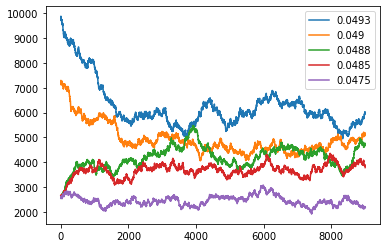

In [5]:
simulate_and_plot([0.0493, 0.0490, 0.0488, 0.0485, 0.0475,],[0.15,0.11,0.04,0.04,0.04], 9000)

/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide


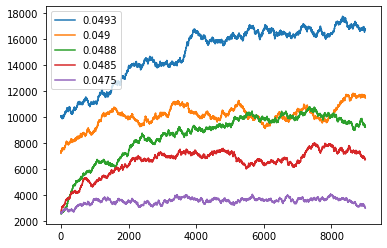

In [6]:
simulate_and_plot([0.0493, 0.0490, 0.0488, 0.0485, 0.0475,],[0.15,0.11,0.04,0.04,0.04], 9000,p_d=0.049)